## MNIST

The following code fetches the MNIST dataset from OpenML.org.

In [1]:
from sklearn.datasets import fetch_openml

mnist =fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y =mnist.data, mnist.target

In [3]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [4]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

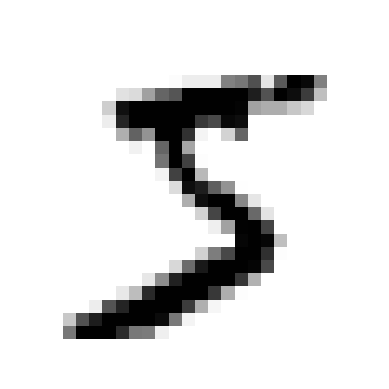

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image =image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit =X[0]
plot_digit(some_digit)
plt.show()

The MNISt dataset returned by fetch_openml() is actually already split into a training set (the first 60,000 images) ans a test set (the last  10000 images):

In [10]:
X_train,X_test,y_train,y_test =X[:60000], X[60000:],y[:60000],y[60000:]

`Training a Binary Classifier`

In [11]:
y_train_5 =(y_train == '5')  # true for all 5s, False for all other digits.
y_test_5 =(y_test == '5')

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf =SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [13]:
# Now we can use it to detect images of the number 5:

sgd_clf.predict([some_digit])

array([ True])

`Measuring Accuracy Using Cross-Validation`

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.dummy import DummyClassifier

dummy_clf =DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [16]:
# Can you guess this model accuracy ? let find out

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

`Confusion Matrices`

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred =cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

cm =confusion_matrix(y_train_5, y_train_pred)

cm

array([[53892,   687],
       [ 1891,  3530]])

In [20]:
y_train_perfect_predictions =y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

`Precison and Recall`

In [21]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))

print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


To compute the F1 score, simply call the f1_score() function:

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

`The Precision/Recall Trade-Off`

In [23]:
y_scores =sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold =0
y_some_digit_pred =(y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the preceding code returns the
same result as the predict() method (i.e., True). Let’s raise the threshold:

In [25]:
threshold =3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
y_scores =cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method ="decision_function")

With these scores, use the precision_recall_curve() function to compute precision
and recall for all possible thresholds (the function adds a last precision of 1 and a last
recall of 0, corresponding to an infinite threshold):

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds =precision_recall_curve(y_train_5, y_scores)

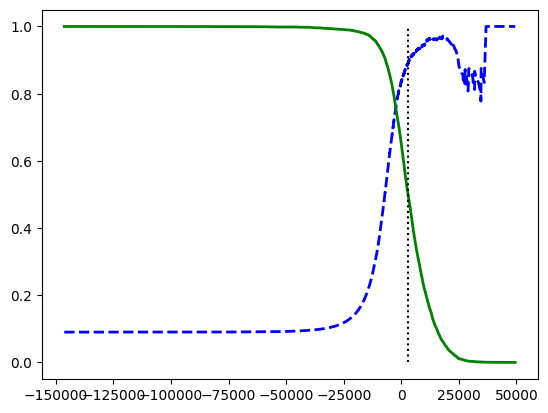

In [28]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
[...]
plt.show()

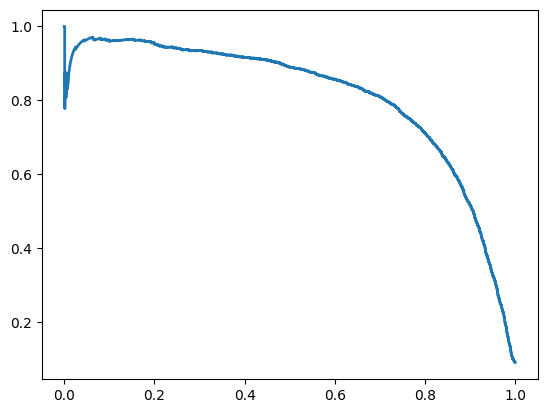

In [29]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
[...]
plt.show()

Numpy aray's argmax() method. This returns the first index of the maximum value, which in this case means the first True value:

In [30]:
idx_for_90_precision =(precisions >=0.90).argmax()
threshold_for_90_precision =thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [31]:
y_train_pred_90 =(y_scores >= threshold_for_90_precision)

In [32]:
precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [33]:
recall_at_90_precision =recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

`THe ROC Curve`

In [34]:
from sklearn.metrics import roc_curve

fpr,tpr, thresholds =roc_curve(y_train_5, y_scores)

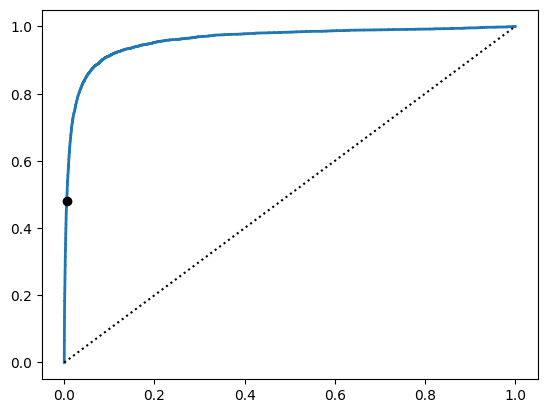

In [36]:
idx_for_threshold_at_90 =(thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 =tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0,1], [0,1], 'k:', label="Random classifier ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="thresholds for 90% precision")
[...]
plt.show()


In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let's now create a RandomClassifier, whose PR curve and F1 score we can compare to those of the SGDClassifier:

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf =RandomForestClassifier(random_state=42)

In [39]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [40]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [41]:
y_scores_forest =y_probas_forest[:, 1]
precision_forest, recalls_forest, thresholds_forest =precision_recall_curve(y_train_5, y_scores_forest)

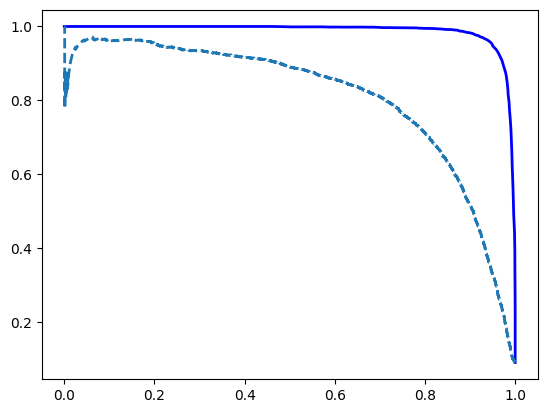

In [42]:
plt.plot(recalls_forest, precision_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

In [43]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

In [45]:
from sklearn.svm import SVC

svm_clf =SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [46]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [47]:
some_digit_scores =svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

THe highest score is 9.3, and its indeed the one corresponding to class 5:

In [48]:
class_id =some_digit.argmax()
class_id

np.int64(161)

In [49]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [51]:
class_id =some_digit_scores.argmax()
class_id

np.int64(5)

In [52]:
svm_clf.classes_[class_id]

'5'

In [53]:
# For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

from sklearn.multiclass import OneVsRestClassifier

ovr_clf =OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

,"estimator estimator: estimator objectA regressor or a classifier that implements :term:`fit`.When a classifier is passed, :term:`decision_function` will be usedin priority and it will fallback to :term:`predict_proba` if it is notavailable.When a regressor is passed, :term:`predict` is used.",SVC(random_state=42)
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation: the `n_classes`one-vs-rest problems are computed in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: 0.20 `n_jobs` default changed from 1 to None",None
,"verbose verbose: int, default=0The verbosity level, if non zero, progress messages are printed.Below 50, the output is sent to stderr. Otherwise, the output is sentto stdout. The frequency of the messages increases with the verbositylevel, reporting all iterations at 10. See :class:`joblib.Parallel` formore details... versionadded:: 1.1",0
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001


In [56]:
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

Training an SGDCLassifier on a multiclass datasets and using it to make predictions is just as easy:

In [57]:
sgd_clf =SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [58]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -19048.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [59]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87745, 0.85835, 0.8698 ])

In [60]:
from sklearn.preprocessing import StandardScaler

scaler =StandardScaler()

X_train_scaled =scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/kshitij/Desktop/Learn_Along_AI-ML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kshitij/Desktop/Learn_Along_AI-ML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kshitij/Desktop/Learn_Along_AI-ML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.89835, 0.8902 , 0.90095])

`Error Analysis`

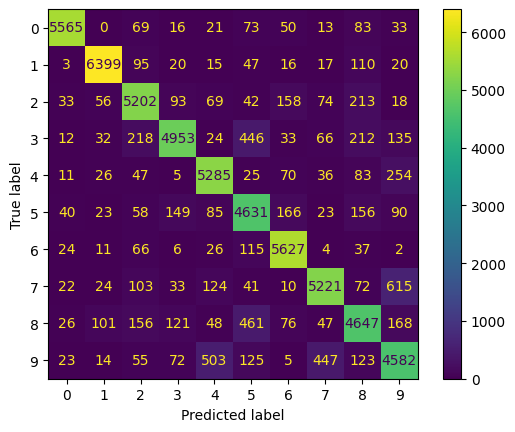

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred =cross_val_predict(sgd_clf, X_train, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

plt.show()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", value_format=".0%")

In [ ]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
sample_weight=sample_weight,
normalize="true", values_format=".0%")

`Multilabel Classification`

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred =cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
from sklearn.multioutput import ClassifierChain

chain_clf =ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])


chain_clf.predict([some_digit])

`Multioutput Classification`

In [ ]:
rng = np.random.default_rng(seed=42)
noise_train = rng.integers(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise_train
noise_test = rng.integers(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf =KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit =knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()